# Single day FWI Reanalysis forecast using 2 day Forcings input

We will do single day FWI-Reanalysis forecast using 2-days input of Temperature, Relative humidity, Total precipitation, and Wind speed. The sample data must span for at least 2 consecutive days. The file format of the stored data should be in netCDF4 format. A pretrained model checkpoint conrresponding to the input and forecast timespan will be required as well.

#### Changing working directory to import modules naturally

In [1]:
import os
os.chdir('../src')
from train import str2num, get_hparams, get_model

#### Importing installed modules

In [2]:
# General functionality
import random
from glob import glob
from argparse import Namespace
import pickle
import tempfile

# Keep the execution uncomplicated
import warnings
warnings.filterwarnings('ignore')

# Ploting purposes
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Scientific computing
import numpy as np
import torch

# Helper modules
import pytorch_lightning as pl
from pytorch_lightning import Trainer

#### Ensuring reproducibility

In [3]:
SEED = 2334
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)

#### Creating pickled list of test-set files

In [4]:
# Only the files needed for output variable are specified.
# Input variable files for corresponding dates are auto-deduced.
test_out_files = [f'/nvme0/fwi-reanalysis/ECMWF_FWI_201904{x:02}_1200_hr_fwi_e5.nc' for x in range(1, 3)]
print("First few files...", *test_out_files[:3], sep='\n')

# Pickling the list which can be used later
with tempfile.NamedTemporaryFile(delete=False) as tmp:
    pickle.dump(test_out_files, tmp)
    test_set_path = tmp.name

First few files...
/nvme0/fwi-reanalysis/ECMWF_FWI_20190401_1200_hr_fwi_e5.nc
/nvme0/fwi-reanalysis/ECMWF_FWI_20190402_1200_hr_fwi_e5.nc


#### Adjusting the knobs

In [8]:
# Storing hyperparamters and configuration in a dictionary
hparams_dict = get_hparams(
    # Feature density of U-Net layers
    init_features=16,
    # Number of input channels (=4*input days)
    in_days=2,
    # Number of prediction channels (=output days)
    out_days=1,
    # Loss metric
    loss='mse',
    # Batch size
    batch_size=1,
    # Number of GPUs to use
    gpus=1,
    # Turn on temporal and spatial constraints for case-study in Australia
    case_study=False,
    # Whether to ignore fire-prone regions
    clip_fwi=False,
    # Pickled list of output files in test-set
    test_set=test_set_path,
    # Model architecture
    model='unet_tapered',
    # Output dataloader
    out='fwi_reanalysis',
    # Directory with FWI Forcings input
    forcings_dir='/nvme1/fwi-forcings',
    # Directory with FWI Renanlysis output
    reanalysis_dir='/nvme0/fwi-reanalysis',
    # Custom mask stored as numpy array
    mask=False,
    # Threshold used to calculate accuracy
    thresh=9.4,
    # Model checkpoint file used to load the pretrained weights
    checkpoint_file='/w/deepfwi/src/model/checkpoints/pre_trained/2_1/epoch_56_100.ckpt'
    )

# Converting the dictionary to Namespace for easier access
hparams = Namespace(**hparams_dict)

 |  init-features -> 16             
 |        in-days -> 2              
 |       out-days -> 1              
 |         epochs -> 100            
 |  learning-rate -> 0.001          
 |           loss -> mse            
 |     batch-size -> 1              
 |          split -> 0.2            
 |      use-16bit -> True           
 |           gpus -> 1              
 |          optim -> one_cycle      
 |        dry-run -> False          
 |     case-study -> False          
 |       clip-fwi -> False          
 |       test-set -> /tmp/tmpjgwsjjdn
 |          model -> unet_tapered   
 |            out -> fwi_reanalysis 
 |   forecast-dir -> /nvme0/wikilimo-remote-gpu-tpu/deepfwi/src
 |   forcings-dir -> /nvme1/fwi-forcings
 | reanalysis-dir -> /nvme0/fwi-reanalysis
 |           mask -> False          
 |         thresh -> 9.4            
 |        comment -> Unet tapered - residual
 |  save-test-set -> False          
 |checkpoint-file -> /w/deepfwi/src/model/checkpoints/pre_trained/

#### Setting the flag for inference

In [9]:
hparams.eval = True

#### Preparing the model

In [10]:
# Create the model architecture and attach with the data
model = get_model(hparams)

# Load the pretrained weights
model.load_state_dict(torch.load(hparams.checkpoint_file)["state_dict"])

# Turn off the gradients
model.eval();

Start date: <xarray.DataArray 'time' ()>
array('2019-04-01T00:00:00.000000000', dtype='datetime64[ns]') 
End date: <xarray.DataArray 'time' ()>
array('2019-04-02T00:00:00.000000000', dtype='datetime64[ns]')


### Manual inference

In [11]:
# Input tensor
x = model.data[0][0].unsqueeze(0)

# Ground truth tensor
y = model.data[0][1].unsqueeze(0)

# Predicted tensor
y_hat = model(x).detach()

# Masking the prediction as done with the ground truth
y_hat[torch.isnan(y)] = torch.tensor(float('nan'))

#### Input variables

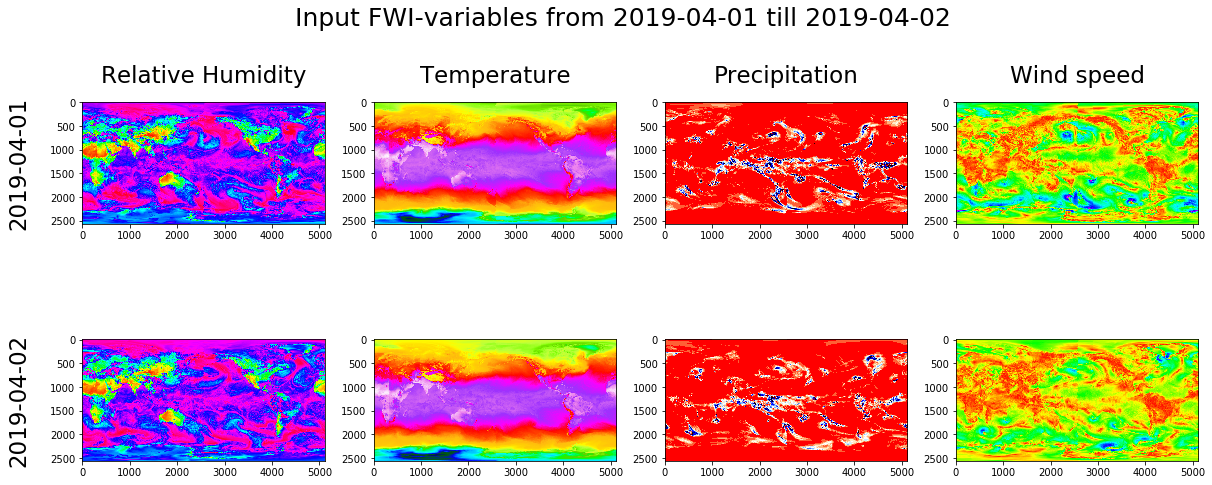

In [20]:
fig=plt.figure(figsize=(20, hparams.in_days*4))
fig.suptitle('Input FWI-variables from 2019-04-01 till 2019-04-02', fontsize=25)
for i in range(hparams.in_days):
    for j in range(4):
        ax = fig.add_subplot(hparams.in_days, 4, 4*i+j+1)
        if i==0:
            if j==0:
                ax.set_title('Relative Humidity',fontsize='23', pad=20)
            elif j==1:
                ax.set_title('Temperature',fontsize='23', pad=20)
            elif j==2:
                ax.set_title('Precipitation',fontsize='23', pad=20)
            else:
                ax.set_title('Wind speed',fontsize='23', pad=20)
        if j==0:
            ax.set_ylabel(f'2019-04-{i+1:02}', fontsize='23', labelpad=20)
        if j==1:
            plt.imshow(x.squeeze()[4*i+j], cmap='gist_ncar')
        elif j==2:
            plt.imshow(x.squeeze()[4*i+j], cmap='flag')
        else:
            plt.imshow(x.squeeze()[4*i+j], cmap='hsv')
plt.show()

*Helper function to add colorbar in the plots.*

In [12]:
def plot(im, title):
    fig, ax = plt.subplots(figsize = (20,10))
    fig.suptitle(title, fontsize=25)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='5%', pad=0.5)
    im = ax.imshow(im, cmap='jet')
    fig.colorbar(im, cax=cax, orientation='horizontal')

#### Ground truth

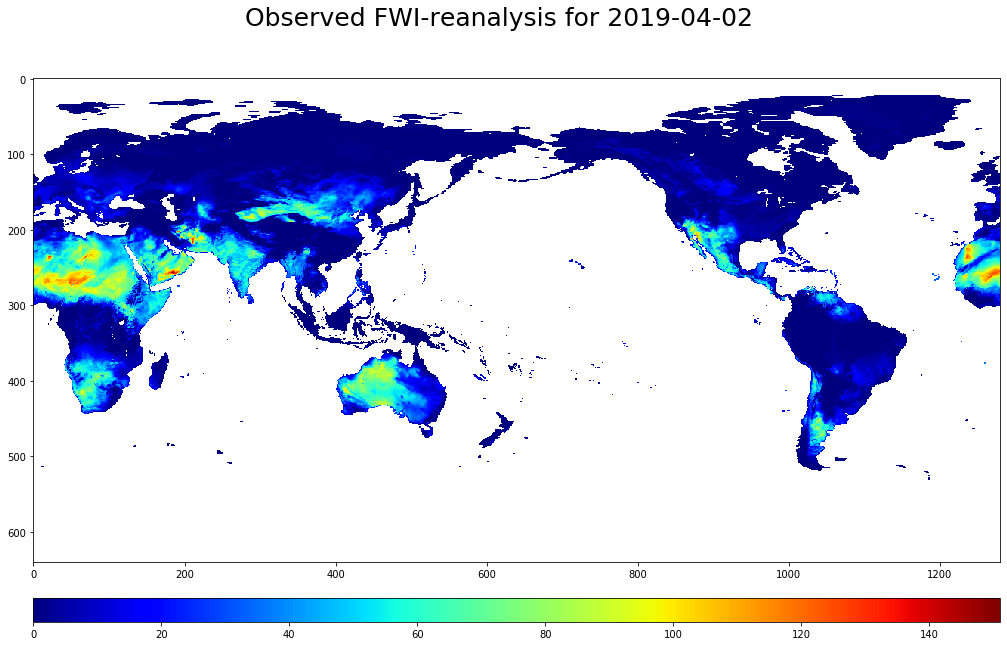

In [11]:
plot(y.squeeze(), 'Observed FWI-reanalysis for 2019-04-02')

#### Prediction

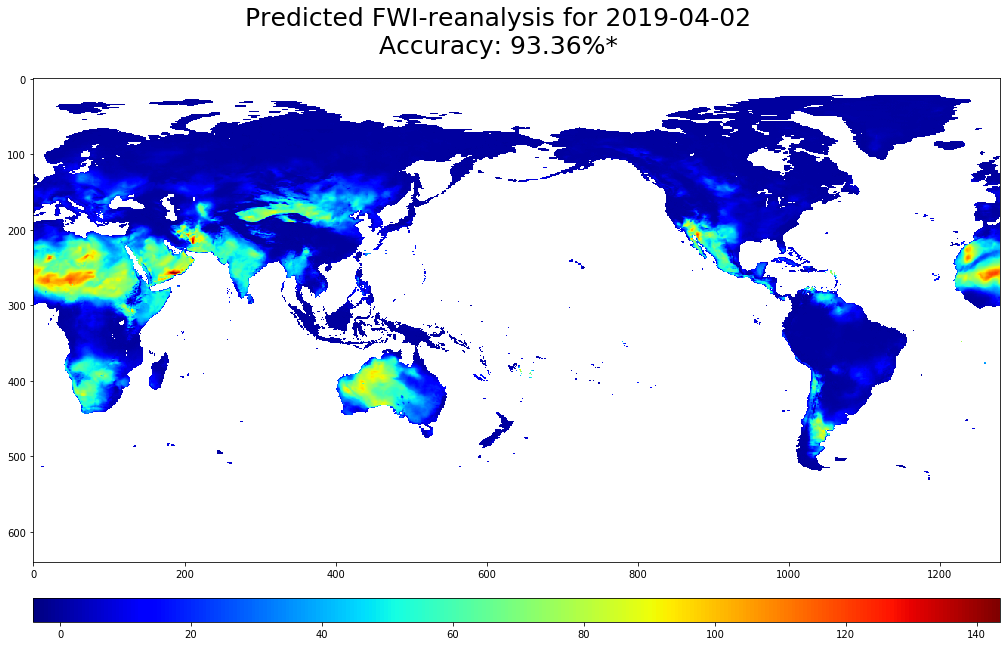

In [41]:
plot(y_hat.squeeze(), f'Predicted FWI-reanalysis for 2019-04-02\nAccuracy: \
{((y-y_hat).abs()<9.4)[model.data.mask.expand_as(y)].float().mean()*100:.2f}%*')

<i>*Using half of MAD as the threshold

#### Prediction error

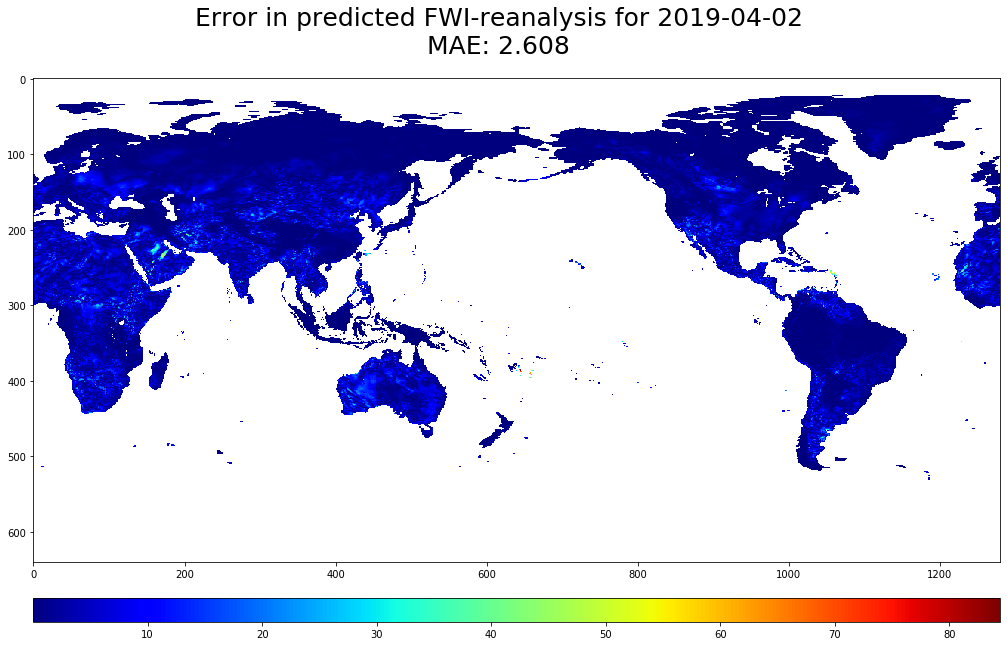

In [42]:
plot((y-y_hat).abs().squeeze(), f"Error in predicted FWI-reanalysis for 2019-04-02\nMAE: \
{((y-y_hat).abs())[model.data.mask.expand_as(y)].float().mean():.3f}")

### Bulk inference

Instead of passing inputs manually to the model, the `Trainer` can be used. It will run the prepared model over the entire data and generate the result metrics.

In [14]:
# Trainer object responsible for running the model
trainer = pl.Trainer(gpus=hparams.gpus)

# Running inference with the supplied model
trainer.test(model)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
Test data loader called.


--------------------------------------------------------------------------------
TEST RESULTS
{'abs_error_0': tensor(2.6077, device='cuda:0'),
 'test_acc_0': tensor(0.9336, device='cuda:0'),
 'test_loss': tensor(21.4521, device='cuda:0'),
 'test_loss_0': tensor(21.4521, device='cuda:0')}
--------------------------------------------------------------------------------



## Conclusion

We did single day global forecast using 2-day input of Relative humidty, Temperature, Total precipitation, and Wind speed. The model gives accuracy of 93.36%, *MAE* of 2.608, and *MSE* of 21.452. We also looked at the error distribution of the prediction across the various regions.